In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import ks_2samp
import plotly.express as px
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [3]:
df = pd.read_csv('dataset/dataset.csv')

In [4]:
df.shape

(49116, 13)

In [5]:
df.head()

,Unnamed: 0,run,Bowler,Batsman,PitchLength,PitchLine,isFour,isSix,isWicket,byes,legbyes,wides,noballs
0,0,0,B Stokes,I Tahir,SHORT,OUTSIDE_OFFSTUMP,0,0,1,0,0,0,0
1,1,0,B Stokes,K Rabada,SHORT,OUTSIDE_OFFSTUMP,0,0,1,0,0,0,0
2,3,0,B Stokes,K Rabada,SHORT,ON_THE_STUMPS,0,0,0,0,0,0,0
3,4,4,B Stokes,K Rabada,SHORT,OUTSIDE_OFFSTUMP,1,0,0,0,0,0,0
4,5,0,L Plunkett,L Ngidi,GOOD_LENGTH,ON_THE_STUMPS,0,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49116 entries, 0 to 49115
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   49116 non-null  int64 
 1   run          49116 non-null  int64 
 2   Bowler       49116 non-null  object
 3   Batsman      49116 non-null  object
 4   PitchLength  49116 non-null  object
 5   PitchLine    49116 non-null  object
 6   isFour       49116 non-null  int64 
 7   isSix        49116 non-null  int64 
 8   isWicket     49116 non-null  int64 
 9   byes         49116 non-null  int64 
 10  legbyes      49116 non-null  int64 
 11  wides        49116 non-null  int64 
 12  noballs      49116 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 4.9+ MB


In [7]:
df.loc[df.duplicated()]

,Unnamed: 0,run,Bowler,Batsman,PitchLength,PitchLine,isFour,isSix,isWicket,byes,legbyes,wides,noballs


In [9]:
unique_count = df['Batsman'].nunique()

print(unique_count)

511


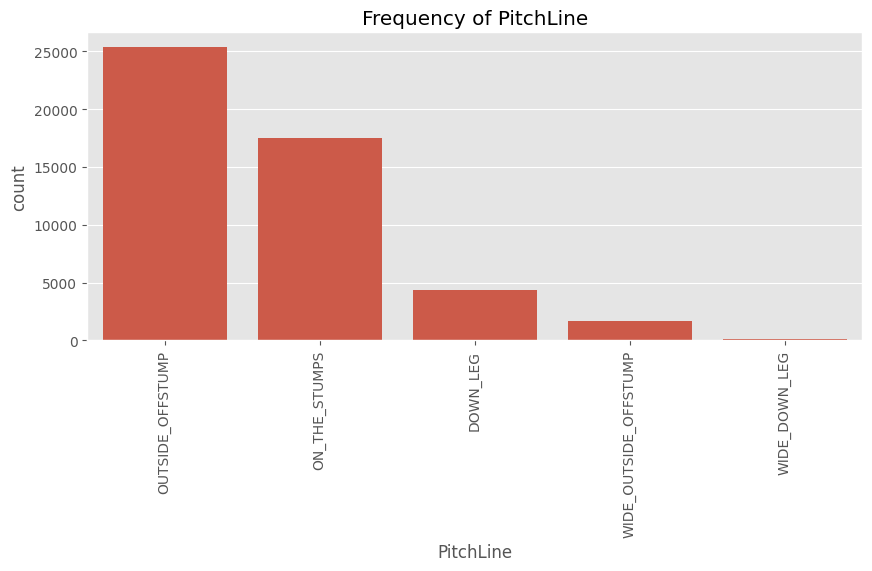

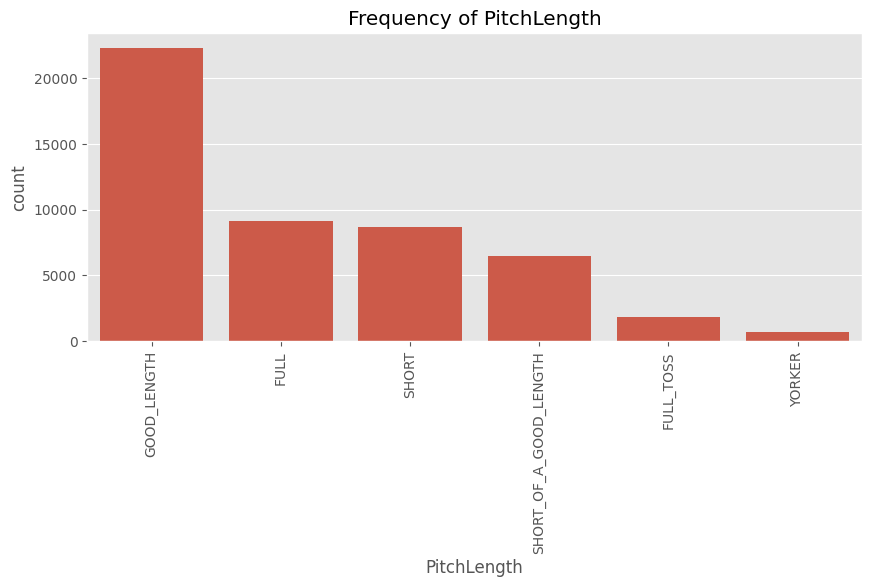

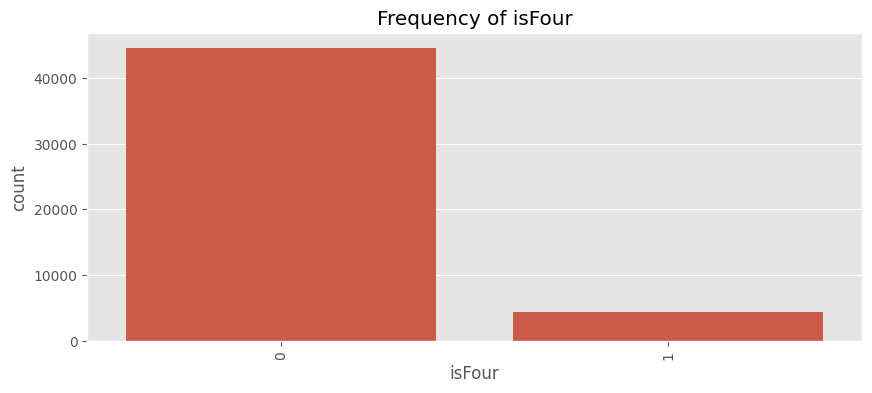

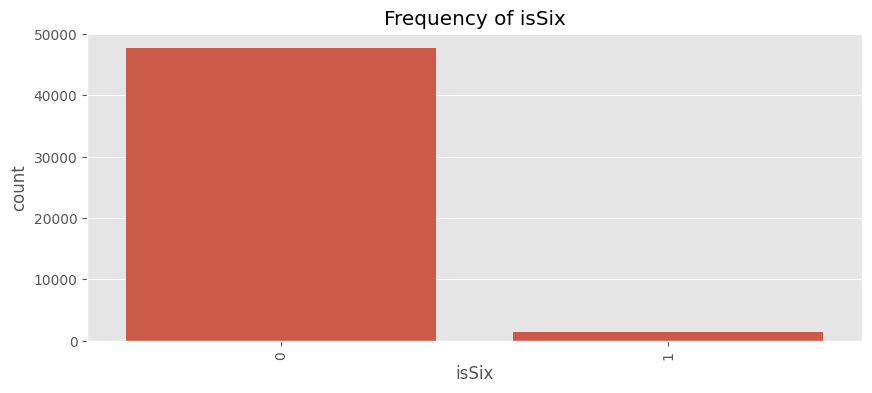

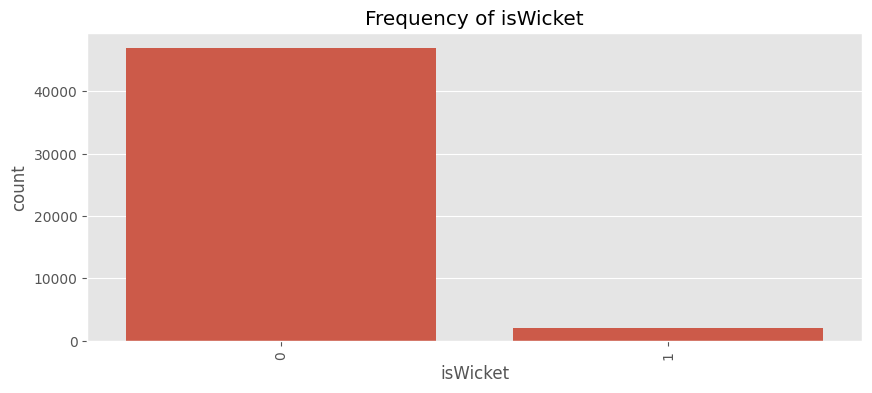

In [11]:
categorical_cols = ['PitchLine', 'PitchLength','isFour','isSix','isWicket']

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title(f"Frequency of {col}")
    plt.xticks(rotation=90)
    plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

df_transformed = df.copy()

numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

scaler = StandardScaler()
df_transformed[numerical_cols] = scaler.fit_transform(df[numerical_cols])

label_encoders = {}
for col in categorical_cols:
    if df[col].nunique() <= 10:
        le = LabelEncoder()
        df_transformed[col] = le.fit_transform(df[col])
        label_encoders[col] = le

df_transformed = pd.get_dummies(df_transformed, columns=[col for col in categorical_cols if col not in label_encoders], drop_first=True)

skewed_cols = df[numerical_cols].apply(lambda x: x.skew()).abs() > 1
for col in numerical_cols[skewed_cols]:
    df_transformed[col] = np.log1p(df[col])

print("\nData Transformation Complete!")
print(df_transformed.head())



Data Transformation Complete!
   Unnamed: 0       run  PitchLength  PitchLine    isFour  isSix  isWicket  \
0   -1.418721  0.000000            3          2  0.000000    0.0  0.693147   
1   -1.418676  0.000000            3          2  0.000000    0.0  0.693147   
2   -1.418586  0.000000            3          1  0.000000    0.0  0.000000   
3   -1.418541  1.609438            3          2  0.693147    0.0  0.000000   
4   -1.418496  0.000000            2          1  0.000000    0.0  0.000000   

   byes  legbyes  wides  noballs  Bowler_A Finch  Bowler_A Markram  \
0   0.0      0.0    0.0      0.0           False             False   
1   0.0      0.0    0.0      0.0           False             False   
2   0.0      0.0    0.0      0.0           False             False   
3   0.0      0.0    0.0      0.0           False             False   
4   0.0      0.0    0.0      0.0           False             False   

   Bowler_A Mathews  Bowler_A Nehra  Bowler_A Nortje  Bowler_A Nurse  \
0      

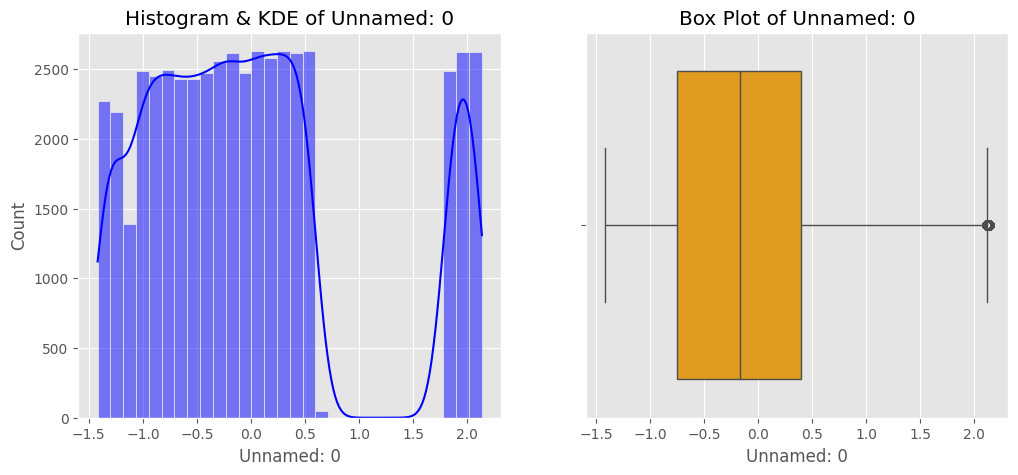

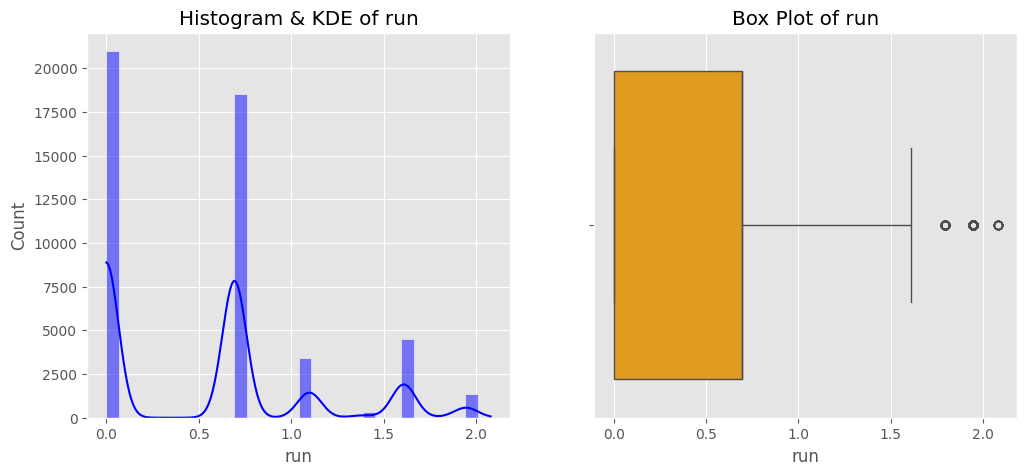

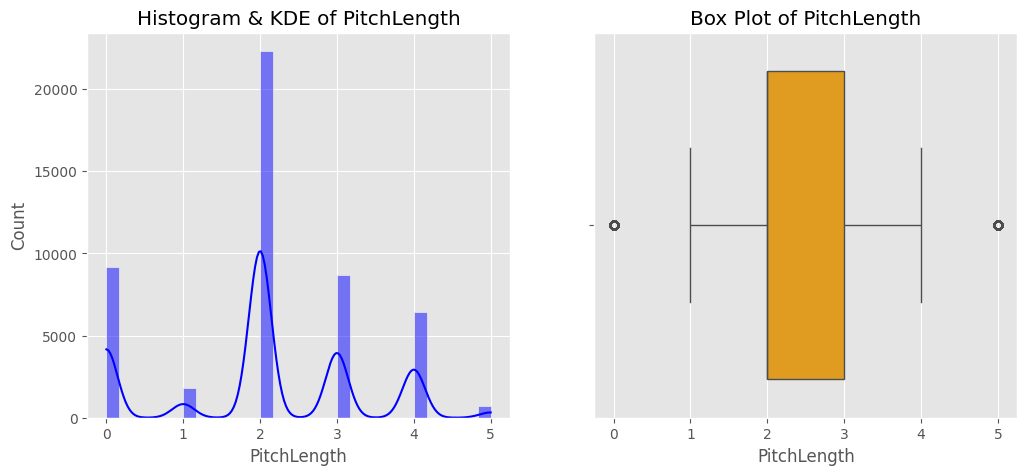

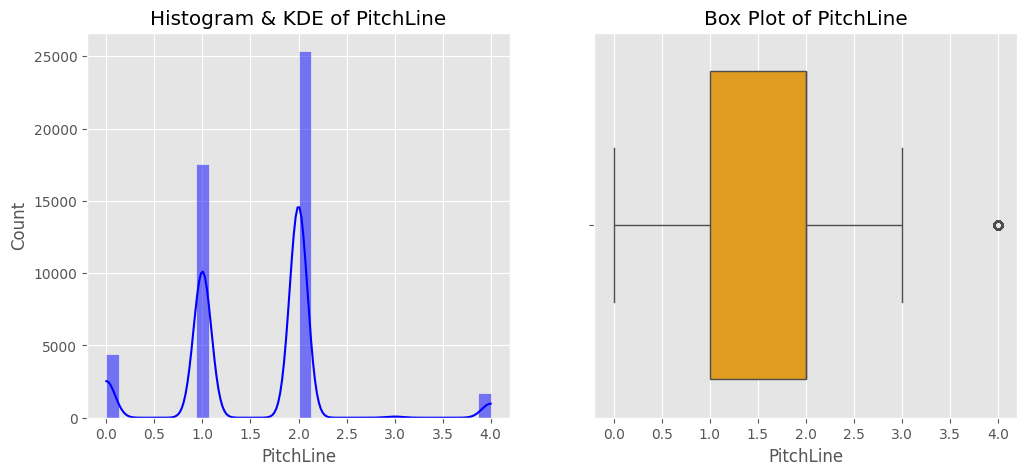

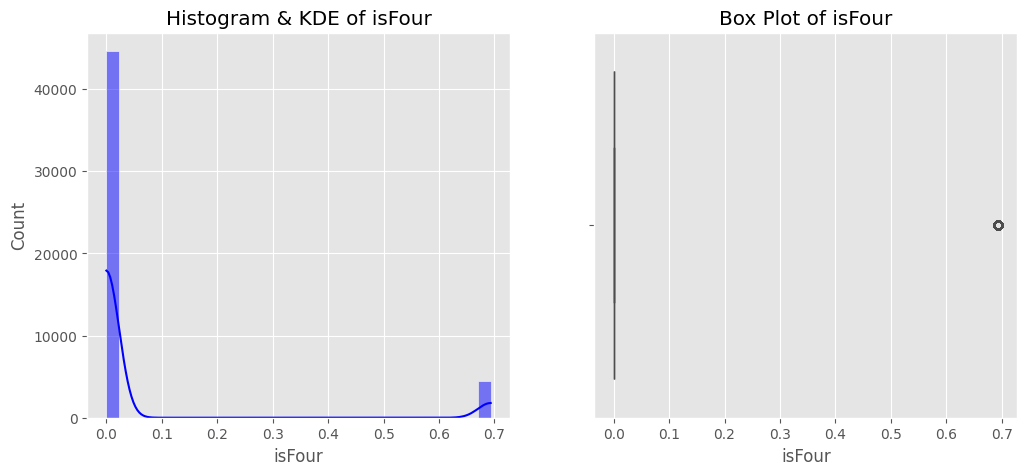

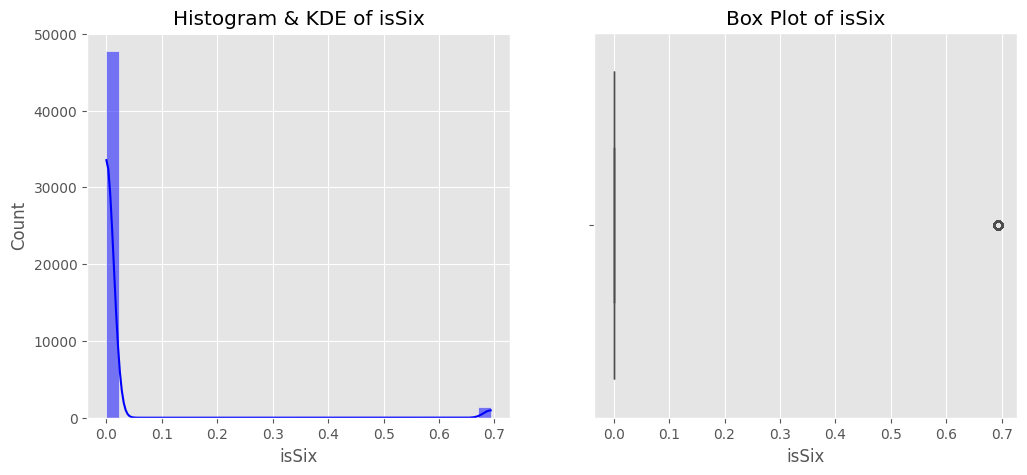

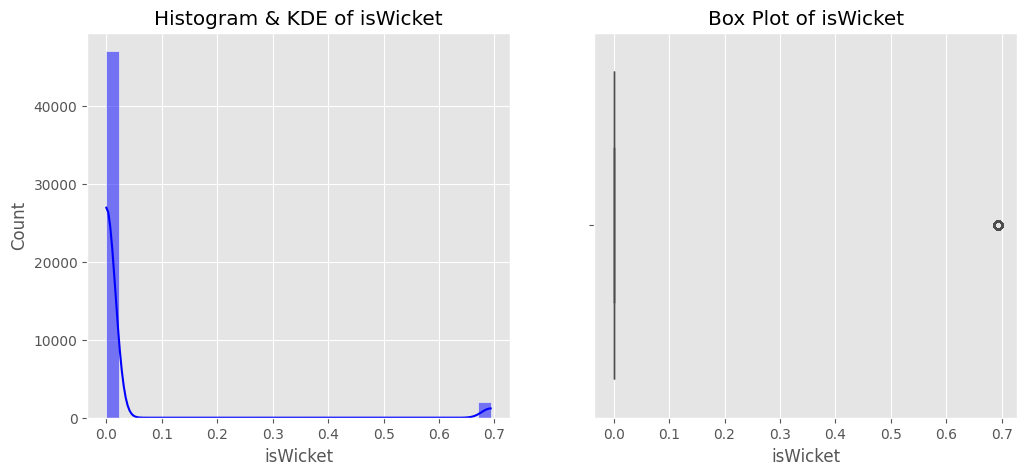

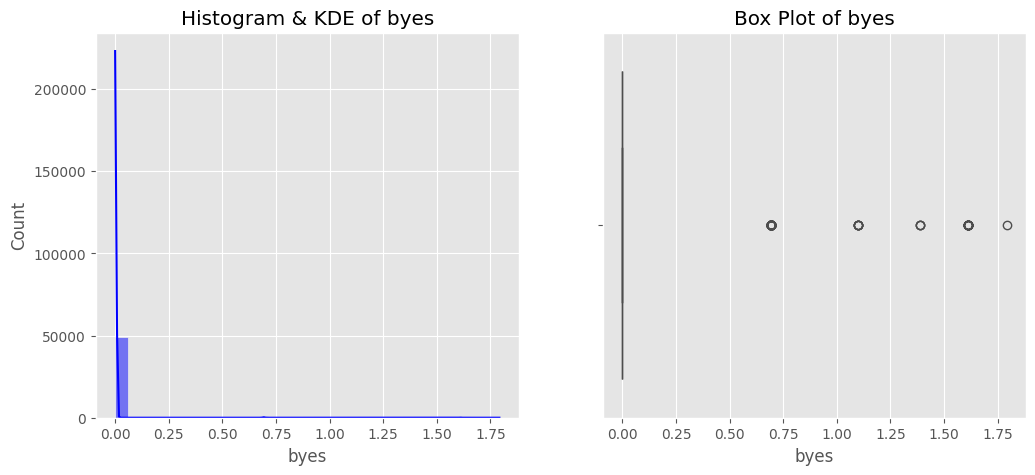

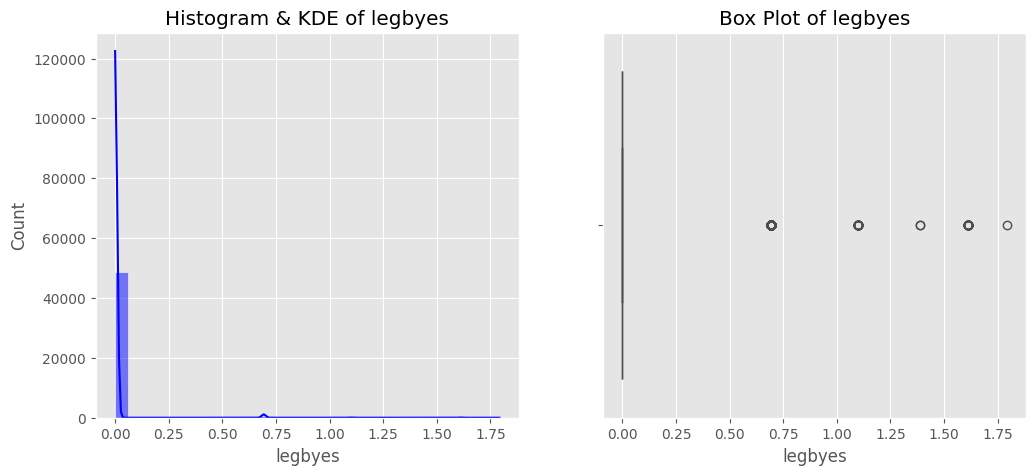

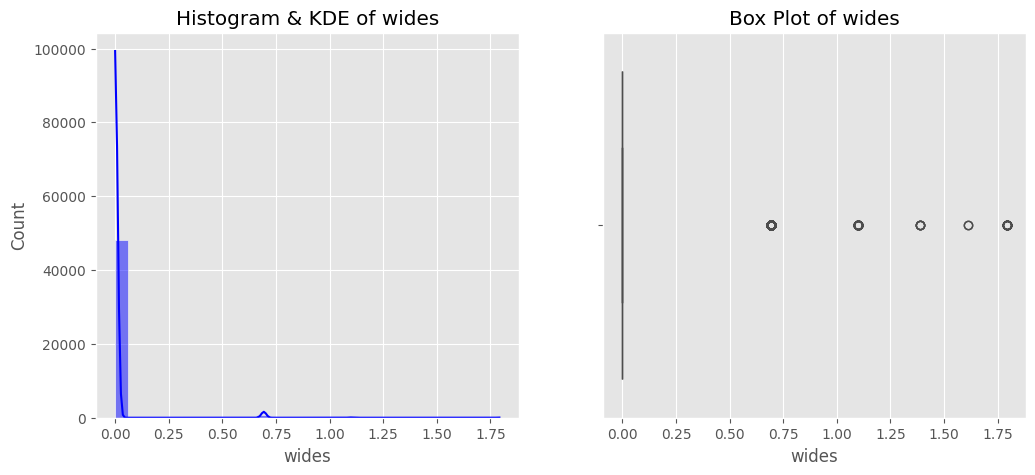

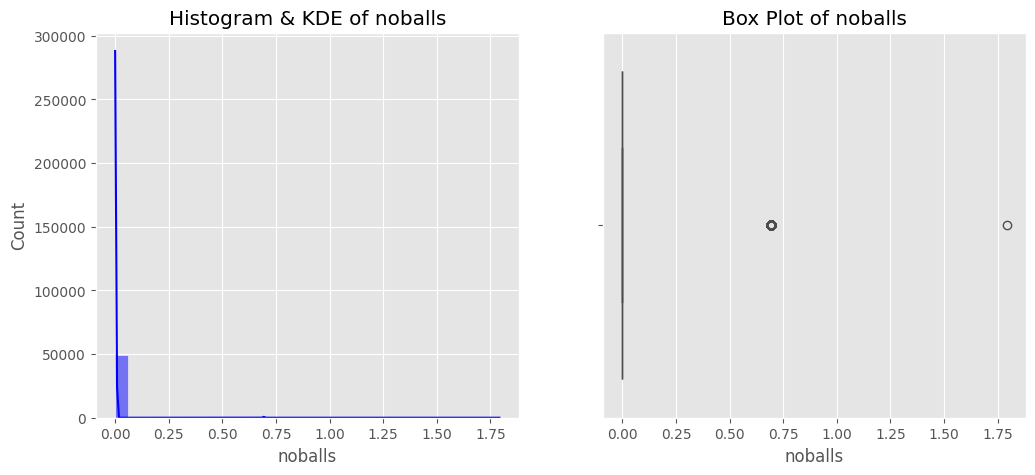

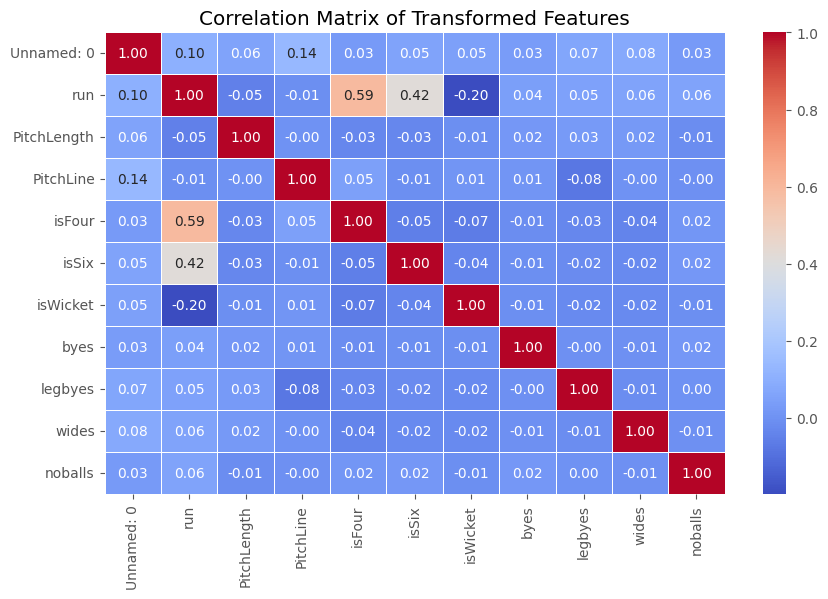

In [13]:
df_viz = df_transformed.copy()

numerical_cols = df_viz.select_dtypes(include=['number']).columns
categorical_cols = [col for col in df_viz.columns if col not in numerical_cols]

for col in numerical_cols:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_viz[col], bins=30, kde=True, color="blue")
    plt.title(f"Histogram & KDE of {col}")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_viz[col], color="orange")
    plt.title(f"Box Plot of {col}")

    plt.show()

if len(numerical_cols) <= 5:
    sns.pairplot(df_viz[numerical_cols], diag_kind="kde", corner=True)
    plt.show()

plt.figure(figsize=(10, 6))
corr_matrix = df_viz[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Transformed Features")
plt.show()


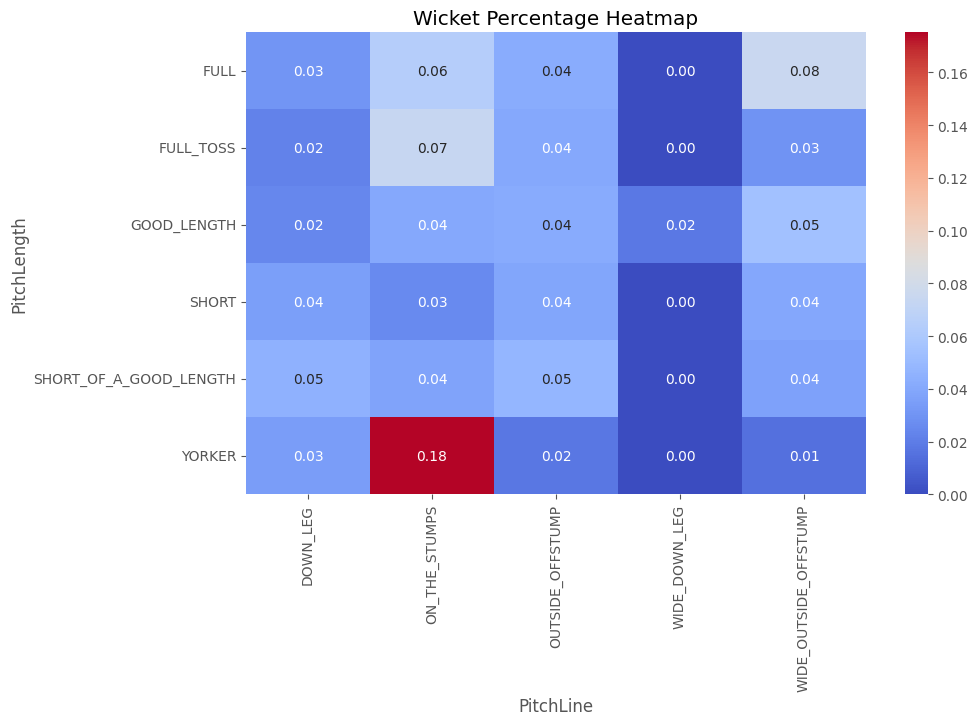

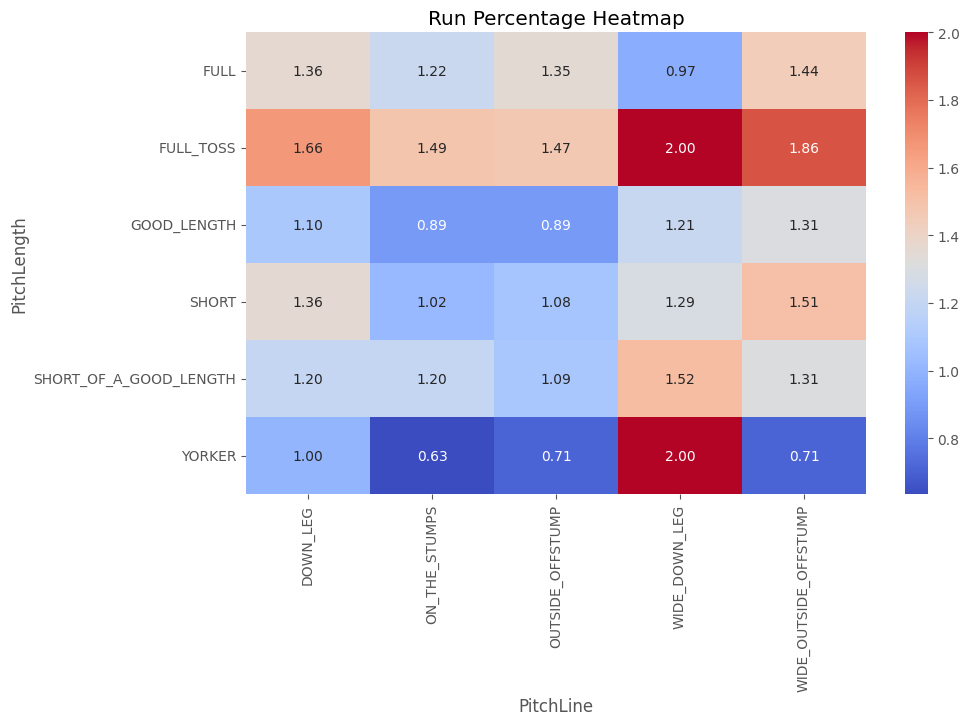

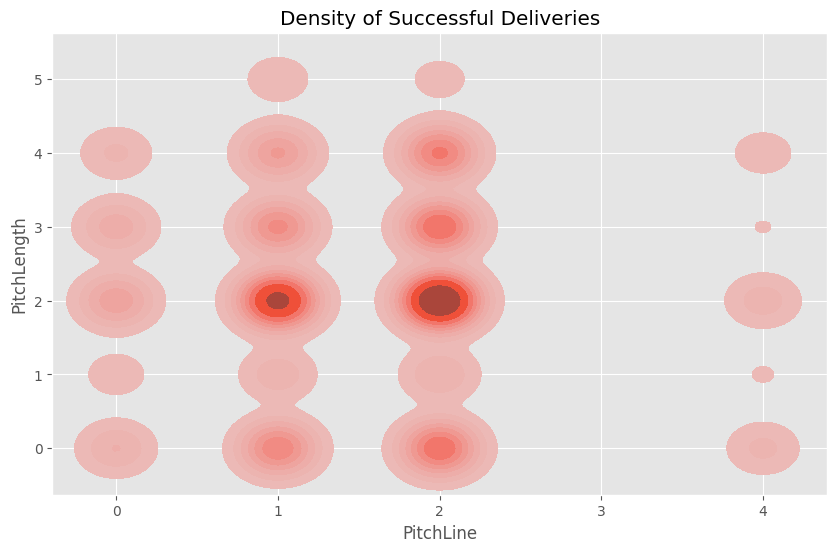

In [16]:
pivot_wicket = df.pivot_table(index='PitchLength', columns='PitchLine', values='isWicket', aggfunc='mean')
pivot_run = df.pivot_table(index='PitchLength', columns='PitchLine', values='run', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_wicket, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Wicket Percentage Heatmap')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_run, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Run Percentage Heatmap')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_transformed, x='PitchLine', y='PitchLength', fill=True)
plt.title('Density of Successful Deliveries')
plt.show()

<Figure size 1200x600 with 0 Axes>

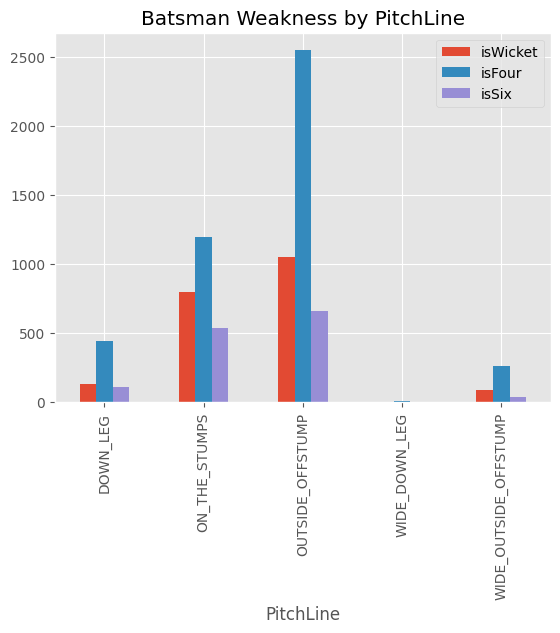

<Figure size 1200x600 with 0 Axes>

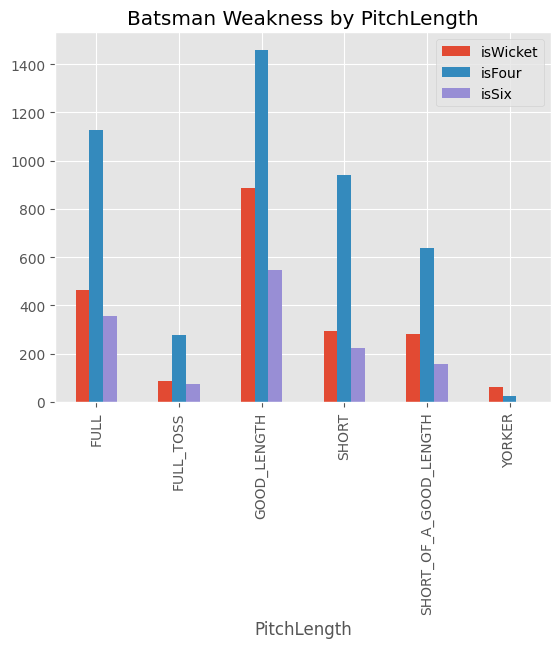

In [17]:
plt.figure(figsize=(12, 6))
df_grouped = df.groupby(['PitchLine'])[['isWicket', 'isFour', 'isSix']].sum().reset_index()
df_grouped.plot(x='PitchLine', kind='bar', stacked=False)
plt.title('Batsman Weakness by PitchLine')
plt.show()

plt.figure(figsize=(12, 6))
df_grouped = df.groupby(['PitchLength'])[['isWicket', 'isFour', 'isSix']].sum().reset_index()
df_grouped.plot(x='PitchLength', kind='bar', stacked=False)
plt.title('Batsman Weakness by PitchLength')
plt.show()

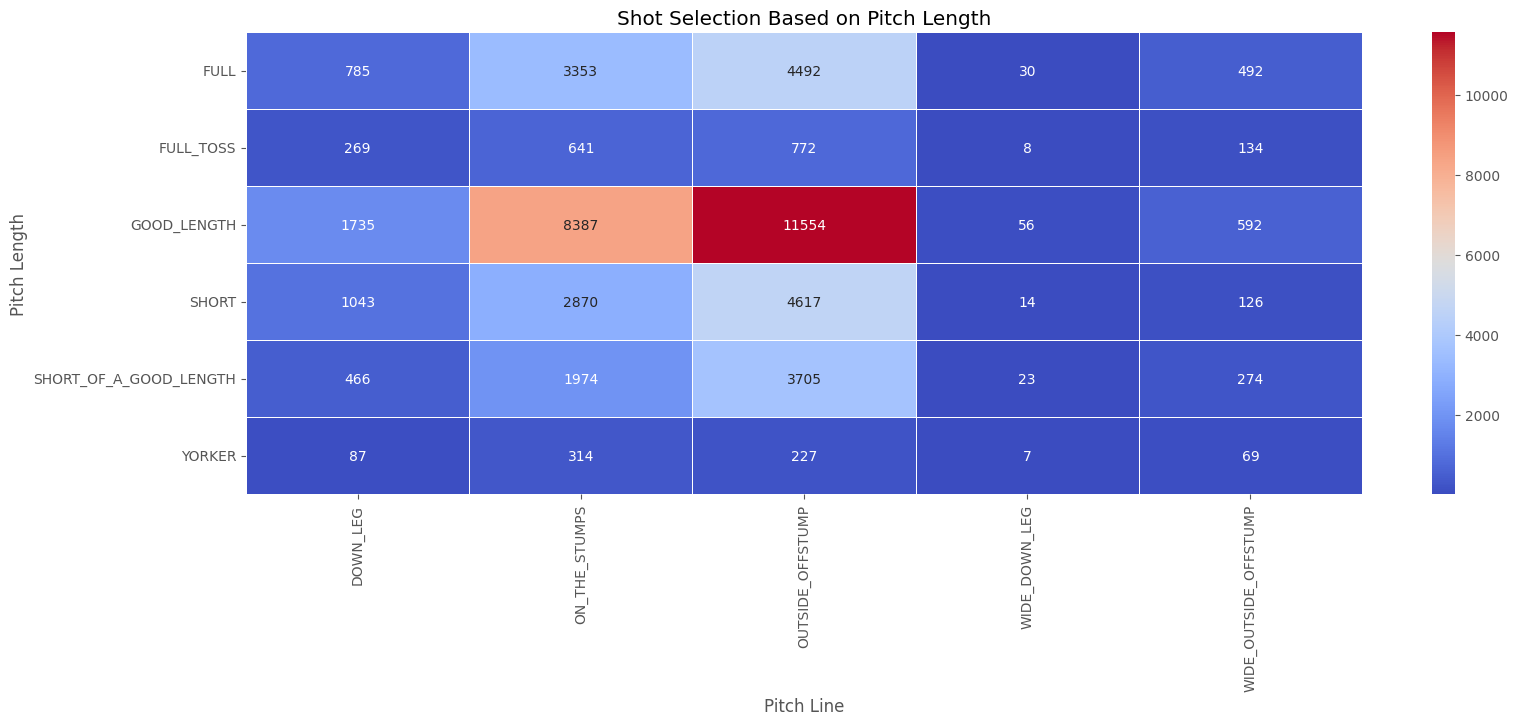

In [20]:
plt.figure(figsize=(18, 6))
pivot_shot_selection = df.pivot_table(index='PitchLength', columns='PitchLine', values='run', aggfunc='count')
sns.heatmap(pivot_shot_selection, cmap='coolwarm', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Shot Selection Based on Pitch Length')
plt.xlabel('Pitch Line')
plt.ylabel('Pitch Length')
plt.xticks(rotation=90)
plt.show()
